In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
def f(x:float,y:float) -> float:
    return ((x-2)**2 / 5 + (y+1)**2 / 250)

#def f(x,y): #rosembrock a=1, b=100
#    return (1-x)**2 + 100* (y - x**2)**2

In [4]:
def get_numerical_gradients(func:callable, x:float,y:float, e:float=0.000000001) -> tuple((float, float)):
    return (func(x+e, y) - func(x-e, y)) / (2*e),  (func(x, y+e) - func(x, y-e)) / (2*e)

In [5]:
iterations=500
init_x, init_y = 10,10
LR=0.1

In [6]:
def sgd_step(func:callable, 
             x:float,y:float, 
             lr:float=LR) -> tuple((float,float)):
    dx, dy = get_numerical_gradients(func,x,y)
    return x - lr* dx, y - lr * dy

def momentum_step(func:callable, 
                  x:float,y:float, 
                  vx:float, vy:float, 
                  lr:float=LR, gamma:float=0.9, nesterov:bool=False) -> tuple((float, float, float, float)):
    if nesterov:
        dx, dy = get_numerical_gradients(func,x-gamma*vx,y-gamma*vy)
    else:
        dx, dy = get_numerical_gradients(func,x,y)
    vx = gamma * vx  + lr * dx
    vy = gamma * vy + lr * dy
    x = x - vx
    y = y - vy
    return x, y, vx, vy


def adagrad_step(func:callable, 
                  x:float,y:float, 
                  dx_history:list, dy_history:list, 
                  lr:float=LR, epsilon:float=0.00001):
    dx, dy = get_numerical_gradients(func,x,y)

    x = x - (lr /np.sqrt((np.sum(np.array(dx_history + [dx])**2)+epsilon)))*dx
    y = y - (lr /np.sqrt((np.sum(np.array(dy_history + [dy])**2)+epsilon)))*dy
    return x,y, dx, dy


def adadelta_step(func:callable, 
                  x:float,y:float, 
                  dx_ma:float, dy_ma:float, x_ma:float, y_ma:float,gamma:float, epsilon:float=0.0001):
    dx, dy = get_numerical_gradients(func,x,y)
    dx_ma = (1-gamma) * dx**2 + gamma * dx_ma
    dy_ma =  (1-gamma) * dy**2 +  gamma * dy_ma

    x = x - (np.sqrt(x_ma+epsilon) / np.sqrt(dx_ma+epsilon))*dx 
    y = y - (np.sqrt(y_ma+epsilon) / np.sqrt(dy_ma+epsilon))*dy 
    return x,y, dx, dy,dx_ma, dy_ma

def rmsprop_step(func:callable, 
                  x:float,y:float, 
                  dx_ma:float, dy_ma:float,gamma:float,
                  lr:float=LR, epsilon:float=0.0001):
    dx, dy = get_numerical_gradients(func,x,y)
    dx_ma = (1-gamma) * dx**2 + gamma * dx_ma
    dy_ma =  (1-gamma) * dy**2 +  gamma * dy_ma
    x = x - (lr /np.sqrt(dx_ma+epsilon))*dx 
    y = y - (lr/np.sqrt(dy_ma+epsilon))*dy 
    return x,y, dx, dy,dx_ma, dy_ma

In [7]:
class Optimizer(object):
    def __init__(self, iterations:int, init_x:float, init_y:float, func:callable, lr:float) -> None:
        self.init_x  = init_x
        self.init_y = init_y
        self.iterations = iterations
        self.func = func
        self.f_values = [self.func(self.init_x, self.init_y)]
        self.x_values = [init_x]
        self.y_values = [init_y]
        self.lr = lr
        self.x = init_x
        self.y = init_y
    def step(self) -> None:
        raise NotImplementedError
    
    def simulate(self) -> None:
        for it in range(self.iterations):
            self.step()
            
    def loss(self, target_x:float, target_y:float):
        return np.sqrt((target_x-self.x)**2 + (target_y - self.y)**2)


In [8]:
class SGD(Optimizer):
    def __init__(self, iterations:int, init_x:float, init_y:float, func:callable, lr:float) -> None:
        super(SGD,self).__init__(iterations, init_x, init_y, func, lr)
    
    def step(self) -> None:
        self.x,self.y = sgd_step(self.func,self.x,self.y)
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)
        

In [9]:
sgd = SGD(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR)
sgd.simulate()

In [10]:
class Momentum(Optimizer):
    def __init__(self, iterations:int, 
                 init_x:float, init_y:float, 
                 func:callable, 
                 lr:float, gamma:float=0.9, nesterov:bool=False) -> None:
        super(Momentum,self).__init__(iterations=iterations,init_x=init_x, init_y=init_y, func=func, lr=lr)
        self.gamma = gamma
        self.vx = 0.0
        self.vy = 0.0
        self.vx_history = []
        self.vy_history = []
        self.nesterov = nesterov
    
    
    def step(self) -> None:
        self.x,self.y, self.vx, self.vy = momentum_step(func=self.func,x=self.x,y=self.y, vx=self.vx, 
                                                          vy=self.vy,gamma=self.gamma, nesterov=self.nesterov)
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)
        self.vx_history.append(self.vx)
        self.vy_history.append(self.vy)

In [11]:
momentum = Momentum(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR)
momentum.simulate()

In [12]:
nesterov = Momentum(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR, nesterov=True)
nesterov.simulate()

In [13]:
class Adagrad(Optimizer):
    def __init__(self, iterations:int, 
                 init_x:float, init_y:float, 
                 func:callable, 
                 lr:float, epsilon:float=0.00000001) -> None:
        super(Adagrad,self).__init__(iterations=iterations,init_x=init_x, init_y=init_y, func=func, lr=lr)
        self.epsilon = epsilon
        self.dx = 0.0
        self.dy = 0.0
        self.dx_history =[]
        self.dy_history = []
       
    
    
    def step(self) -> None:
        self.x,self.y, self.dx, self.dy = adagrad_step(func=self.func,x=self.x,y=self.y, 
                                                               dx_history=self.dx_history, 
                                                               dy_history=self.dy_history,
                                                               epsilon=self.epsilon)
        
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)
        self.dx_history.append(self.dx)
        self.dy_history.append(self.dy)

In [14]:
adagrad = Adagrad(iterations=iterations,init_x=init_x,init_y=init_y,func=f,lr=LR)
adagrad.simulate()

In [15]:
class Adadelta(Optimizer):
    def __init__(self, iterations:int, 
                 init_x:float, init_y:float, 
                 func:callable, 
                 gamma:float,
                 lr:float,
                 epsilon:float=0.00000001) -> None:
        super(Adadelta,self).__init__(iterations=iterations,init_x=init_x, init_y=init_y, func=func, lr=lr)
        self.epsilon = epsilon
        self.gamma = gamma
        self.dx = 0.0
        self.dy = 0.0
        self.dx_ma = 0.0
        self.dy_ma = 0.0
        self.x_ma = init_x
        self.y_ma = init_y
    
    
    def step(self) -> None:
        
        self.x,self.y, self.dx, self.dy, self.dx_ma, self.dy_ma = adadelta_step(func=self.func,x=self.x,y=self.y, 
                                                               dx_ma=self.dx_ma, 
                                                               dy_ma=self.dy_ma,
                                                               x_ma = self.x_ma,
                                                               y_ma = self.y_ma,
                                                               epsilon=self.epsilon, gamma=self.gamma)
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)
#         print("new dx ma {}, new dy ma  {}".format(self.dx_ma, self.dy_ma))     
        self.x_ma = (1-self.gamma) * self.x**2 + self.gamma * self.x_ma
        self.y_ma =  (1-self.gamma) * self.y**2 +  self.gamma * self.y_ma
        

In [16]:
adadelta = Adadelta(iterations=iterations,init_x=init_x,init_y=init_y,func=f, gamma=0.9, lr=LR)
adadelta.simulate()

In [17]:
class RMSProp(Optimizer):
    def __init__(self, iterations:int, 
                 init_x:float, init_y:float, 
                 func:callable, 
                 gamma:float,
                 lr:float,
                 epsilon:float=0.00000001) -> None:
        super(RMSProp,self).__init__(iterations=iterations,init_x=init_x, init_y=init_y, func=func, lr=lr)
        self.epsilon = epsilon
        self.gamma = gamma
        self.dx = 0.0
        self.dy = 0.0
        self.dx_ma = 0.0
        self.dy_ma = 0.0
    
    def step(self) -> None:
        
        self.x,self.y, self.dx, self.dy, self.dx_ma, self.dy_ma = rmsprop_step(func=self.func,x=self.x,y=self.y, 
                                                               dx_ma=self.dx_ma, 
                                                               dy_ma=self.dy_ma,
                                                               lr=self.lr,
                                                               epsilon=self.epsilon, gamma=self.gamma)
        self.x_values.append(self.x)
        self.y_values.append(self.y )
        loss = self.func(self.x,self.y)
        self.f_values.append(loss)


In [18]:
rmsprop = RMSProp(iterations=iterations,init_x=init_x,init_y=init_y,func=f, gamma=0.9, lr=LR)
rmsprop.simulate()

<IPython.core.display.Javascript object>


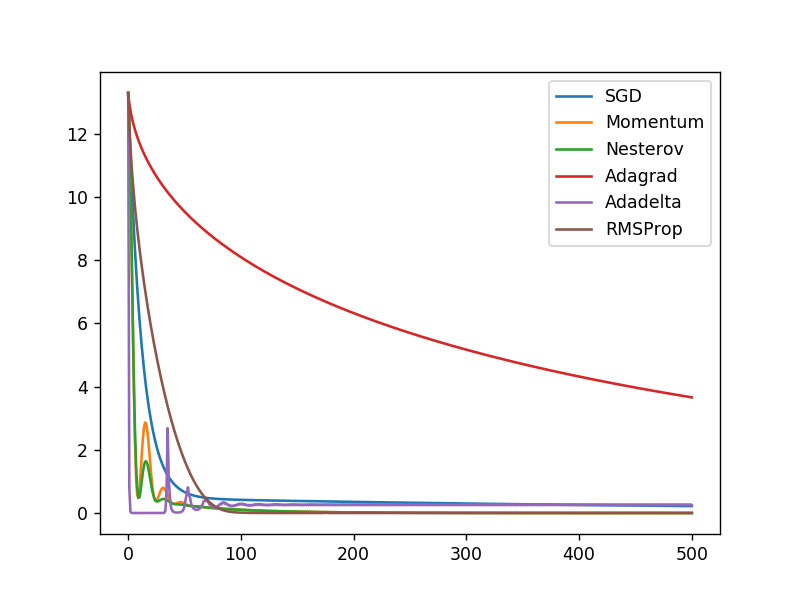

In [19]:
plt.plot(sgd.f_values, label='SGD')
plt.plot(momentum.f_values, label='Momentum')
plt.plot(nesterov.f_values, label='Nesterov')
plt.plot(adagrad.f_values, label='Adagrad')
plt.plot(adadelta.f_values, label='Adadelta')
plt.plot(rmsprop.f_values, label='RMSProp')
plt.legend();

<IPython.core.display.Javascript object>


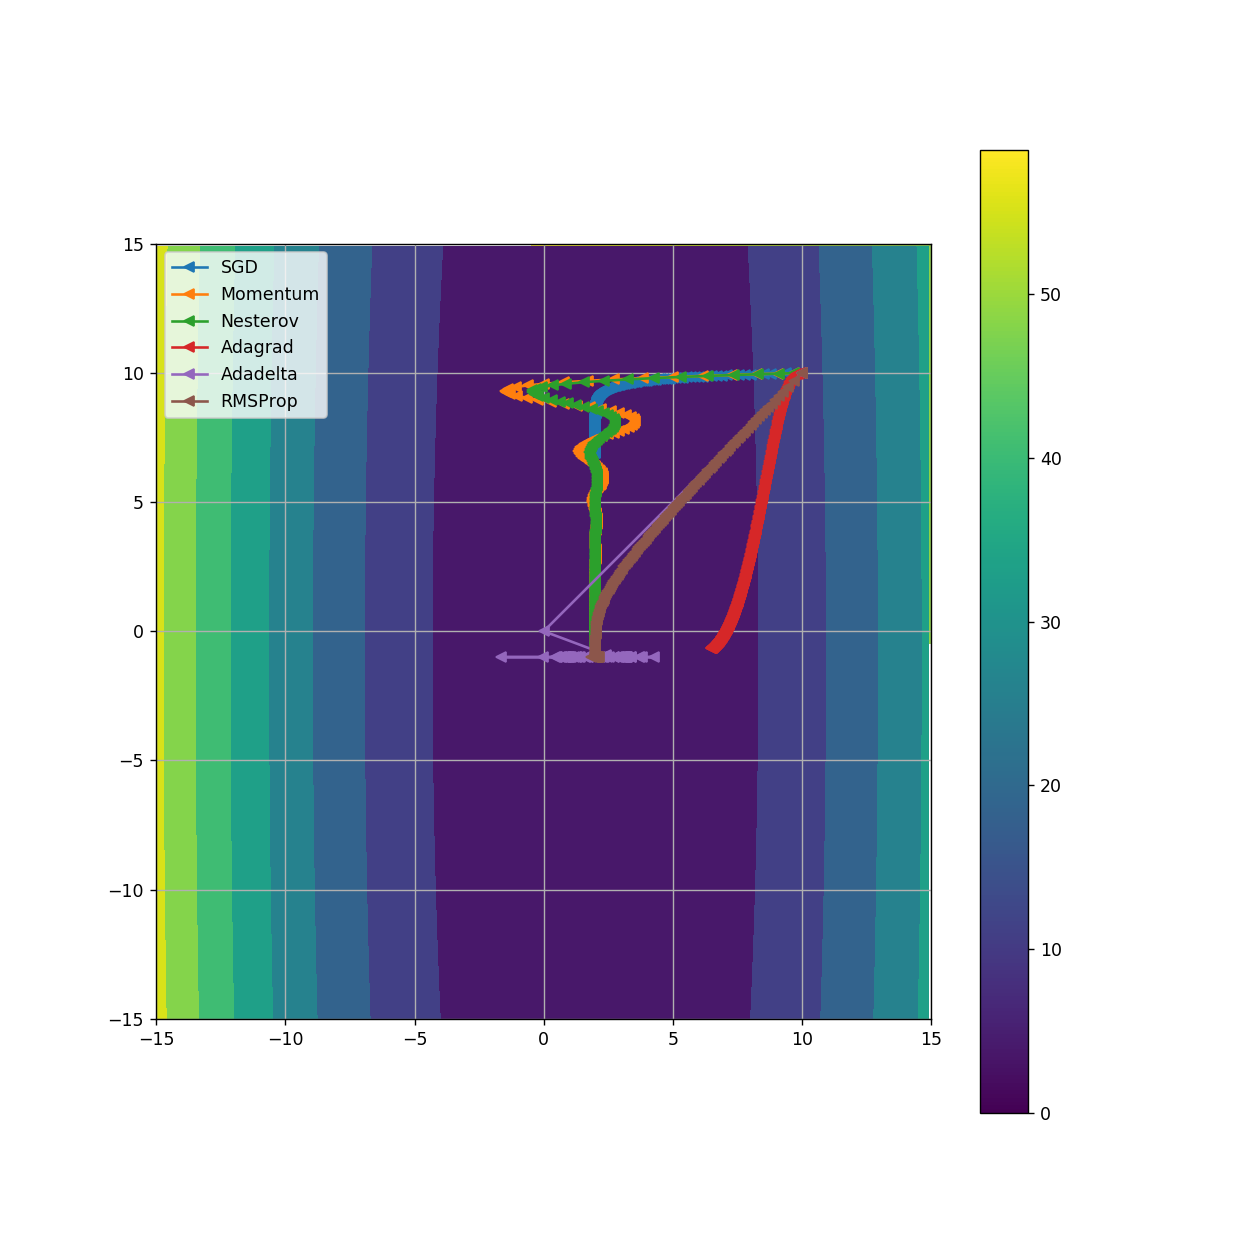

In [20]:

X_MIN, X_MAX, Y_MIN, Y_MAX = -15, 15, -15, 15
STEP = 0.1
X,Y = np.meshgrid(np.arange(X_MIN, X_MAX, STEP), np.arange(Y_MIN, Y_MAX, STEP))
# X,Y = np.meshgrid(np.arange(-x_max,x_max,0.1), np.arange(-y_max,y_max,0.1))
Z = f(X,Y)

x_sgd_anim = []
y_sgd_anim = []
x_momentum_anim = []
y_momentum_anim = []
x_nesterov_anim = []
y_nesterov_anim = []
x_adagrad_anim = []
y_adagrad_anim = []
x_adadelta_anim = []
y_adadelta_anim = []
x_rmsprop_anim = []
y_rmsprop_anim = []

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)

line_sgd, = ax.plot(0, 0, marker='<', label='SGD')
line_mom, = ax.plot(0, 0, marker='<', label='Momentum')
line_nesterov, = ax.plot(0, 0, marker='<', label='Nesterov')
line_adagrad, = ax.plot(0, 0, marker='<', label='Adagrad')
line_adadelta, = ax.plot(0, 0, marker='<', label='Adadelta')
line_rmsprop, = ax.plot(0, 0, marker='<', label='RMSProp')
plt.legend()
ax.contourf(X,Y, Z)

def animation_frame(step):
    x_sgd_anim.append(step[0])
    y_sgd_anim.append(step[1])
    x_momentum_anim.append(step[2])
    y_momentum_anim.append(step[3])
    x_nesterov_anim.append(step[4])
    y_nesterov_anim.append(step[5])
    x_adagrad_anim.append(step[6])
    y_adagrad_anim.append(step[7])   
    x_adadelta_anim.append(step[8])
    y_adadelta_anim.append(step[9])
    x_rmsprop_anim.append(step[10])
    y_rmsprop_anim.append(step[11])
    
    line_sgd.set_xdata(x_sgd_anim)
    line_sgd.set_ydata(y_sgd_anim)
    line_mom.set_xdata(x_momentum_anim)
    line_mom.set_ydata(y_momentum_anim)
    line_nesterov.set_xdata(x_nesterov_anim)
    line_nesterov.set_ydata(y_nesterov_anim)
    line_adagrad.set_xdata(x_adagrad_anim)
    line_adagrad.set_ydata(y_nesterov_anim)
    line_adadelta.set_xdata(x_adadelta_anim)
    line_adadelta.set_ydata(y_adadelta_anim)
    line_rmsprop.set_xdata(x_rmsprop_anim)
    line_rmsprop.set_ydata(y_rmsprop_anim)
    return line_sgd,line_mom, line_nesterov,line_adagrad,line_adadelta,line_rmsprop,


frames = np.array([[x1,y1,x2,y2, x3,y3, x4,y4, x5,y5,x6,y6] for x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6 in 
                   zip(sgd.x_values, sgd.y_values, 
                       momentum.x_values,momentum.y_values, 
                       nesterov.x_values,nesterov.y_values,
                       adagrad.x_values, adagrad.y_values, 
                       adadelta.x_values, adadelta.y_values,
                       rmsprop.x_values, rmsprop.y_values)] )
animation = FuncAnimation(fig, func=animation_frame, frames=frames, interval=100)

plt.imshow(Z)
plt.colorbar()
plt.grid()
plt.show();

